<a href="https://colab.research.google.com/github/saahil4real/18103041/blob/master/Ravishankar/After%20Sensitivity%20Analysis/RavishankarSA_NSGA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ravishankar.ods to ravishankar.ods


In [ ]:
!git clone https://github.com/Project-Platypus/Platypus.git
!cd Platypus &&  python setup.py install
!mv Platypus/* .
!pip install odfpy

Cloning into 'Platypus'...
remote: Enumerating objects: 1078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1078 (delta 5), reused 5 (delta 1), pack-reused 1056
Receiving objects: 100% (1078/1078), 905.36 KiB | 3.04 MiB/s, done.
Resolving deltas: 100% (733/733), done.
running install
running bdist_egg
running egg_info
creating Platypus_Opt.egg-info
writing Platypus_Opt.egg-info/PKG-INFO
writing dependency_links to Platypus_Opt.egg-info/dependency_links.txt
writing requirements to Platypus_Opt.egg-info/requires.txt
writing top-level names to Platypus_Opt.egg-info/top_level.txt
writing manifest file 'Platypus_Opt.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'dist'
adding license file 'COPYING'
writing manifest file 'Platypus_Opt.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating bui

In [ ]:
from platypus import *
from platypus.types import  Real
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_lists():
    global reservoir_areas
    df = pd.read_excel('ravishankar.ods', engine='odf')
    inflow = np.asarray(df["Inflow \n(MCM)"])
    evap = np.asarray(df["Evaporation\n(MCM)"])
    # evap = evap*(reservoir_areas[0]/1000.0) # For uniform dimensions. We want all to be in MCM. evap is in mm, area in km^2, hence divide by 1000
    return inflow, evap


def expressions(vars):
    global N
    global Obj_num
    global Constraints_num
    global S_max
    Inflow, Evap = get_lists()
    objs=[]
    obj1=(-1.0*np.sum(np.asarray([(vars[i]-vars[(N//2+i)]) for i in range(N//2)]))) # Obj function: Max z = ∑ S_t − Q_t
    
    objs.append(obj1)
    constraints = [(vars[i+1]-vars[i]-Inflow[i]+ vars[(N//2+i)] + Evap[i] + max(0,vars[i+1]-S_max)) for i in range(N//2-1) ]
    # print("DEBUG: objs.shape: ", len(objs), " constraints.len: ", len(constraints))
    return objs, constraints

# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()



N=int(324*2) # Decision Vars 324 S_t and 324 Q_t
Obj_num =1
S_min=143.6 #in mcm
S_max=910.5
Q_max = 1539.0
Constraints_num =int(N/2)-1  #S_t+1 = S_t + I_t − Q_t − E_t − O_t
# reservoir_areas=[267.97]  # list of areas of reservoirs [BARGI: km^2]
constraint=[]

for i in range(N//2):
    constraint.append(Real(S_min, S_max)) # S_min <= S_t <=S_max
for i in range(N//2):
    constraint.append(Real(0.01, Q_max))

# algorithms = [NSGAII, (NSGAIII, {"divisions_outer":12})]

problem = Problem(N, Obj_num, Constraints_num)
problem.types[:] = constraint
problem.constraints[:] = "==0"
problem.function = expressions  

"""
NSGAII
Parameters:	
- problem (Problem) – the problem definition
- population_size (int) – the size of the population
- generator (Generator) – the generator for initializing the population
- selector (Selector) – the selector for selecting parents during recombination
- variator (Variator) – the recombination operator
"""


'\nNSGAII\nParameters:\t\n- problem (Problem) – the problem definition\n- population_size (int) – the size of the population\n- generator (Generator) – the generator for initializing the population\n- selector (Selector) – the selector for selecting parents during recombination\n- variator (Variator) – the recombination operator\n'

In [ ]:
#population size: 100-1000
result_dict ={}
for pop_size in range(100,1001,100):
    print("Beginning pop_size: ", pop_size)
    algorithm = NSGAII(problem, population_size=pop_size)
    algorithm.run(10)
    feasible_solutions = [s for s in algorithm.result if s.feasible]
    nondominated_solutions = nondominated(algorithm.result)
    # print("# Feasible solutions: ", len(feasible_solutions))
    result = algorithm.result
    result_list = []
    num_solutions = len(result)
    # print(num_solutions)
    # printProgressBar(0, num_solutions, prefix = 'Progress:', suffix = 'Complete', length = 50)
    counterr=0
    sum_objs = 0
    for solution in result:
        # print("Count: ", counterr)
        counterr+=1
        printProgressBar(counterr + 1, num_solutions, prefix = 'Progress:', suffix = 'Complete', length = 50)
        result_list.append(solution.objectives[0])
        sum_objs += solution.objectives[0]
    result_dict[str(pop_size)] = result_list
    print(result_list)
    #print(min(result_list))
    print("Average Objective Value for pop_size ", pop_size, " : ", max(result_list) )

with open("NSGA2_population_size.dict", "wb") as f:
    pickle.dump(result_dict,f)



Beginning pop_size:  100
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[77362.82570053871, 82891.24201414581, 76038.8669681267, 67274.64104260714, 76245.53809219845, 73948.65464273063, 63761.19647172177, 65663.6093237666, 65747.22331611012, 72782.28529816825, 71194.5362324671, 69374.0302607206, 74698.19456816805, 87843.39812450417, 80332.86655176248, 75739.36177233397, 89261.31622105223, 88565.9225125412, 81562.42396584222, 59458.23318397226, 78546.36834592071, 86253.58789780816, 79140.692706056, 67695.73659284684, 77434.48840547405, 66031.903069871, 86433.95757025841, 65529.76714481159, 71174.07592451456, 81412.89840110496, 89839.82782121477, 78493.59974952707, 71878.95997585478, 69634.59644327813, 79647.83206565992, 90477.0294914894, 71383.3036120201, 85527.14720191539, 75824.67263101677, 69313.81644150318, 74410.95488227834, 92258.22803386863, 67058.84310955487, 73999.6835267435, 81431.86433802964, 74484.50505282223, 96332.66462346261, 80619.96706656

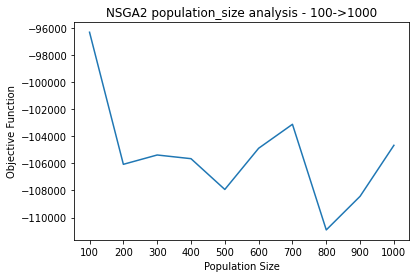

In [ ]:
with open("NSGA2_population_size.dict", "rb") as f:
    result_dict = pickle.load(f)
plot_y=[]
# pop_size_df = pd.DataFrame.from_dict(result_dict)

for pop_size in result_dict.keys():
    plot_y.append(-1*(np.asarray(result_dict[pop_size]).max()))
plt.plot(list(result_dict.keys()), plot_y)
plt.title("NSGA2 population_size analysis - 100->1000")
plt.xlabel("Population Size")
plt.ylabel("Objective Function")
plt.show()

In [ ]:
#population size: 100-1000
result_dict ={}
for pop_size in range(50,151,10):
    print("Beginning pop_size: ", pop_size)
    algorithm = NSGAII(problem, population_size=pop_size)
    algorithm.run(10)
    feasible_solutions = [s for s in algorithm.result if s.feasible]
    nondominated_solutions = nondominated(algorithm.result)
    # print("# Feasible solutions: ", len(feasible_solutions))
    result = algorithm.result
    result_list = []
    num_solutions = len(result)
    # print(num_solutions)
    # printProgressBar(0, num_solutions, prefix = 'Progress:', suffix = 'Complete', length = 50)
    counterr=0
    sum_objs = 0
    for solution in result:
        # print("Count: ", counterr)
        counterr+=1
        printProgressBar(counterr + 1, num_solutions, prefix = 'Progress:', suffix = 'Complete', length = 50)
        result_list.append(solution.objectives[0])
        sum_objs += solution.objectives[0]
    result_dict[str(pop_size)] = result_list
    #print(result_list)
    #print(min(result_list))
    print("Average Objective Value for pop_size ", pop_size, " : ", max(result_list) )

with open("NSGA2_population_size_fine_tune.dict", "wb") as f:
    pickle.dump(result_dict,f)


Beginning pop_size:  50
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  50  :  101060.3505903294
Beginning pop_size:  60
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  60  :  95061.50111328106
Beginning pop_size:  70
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  70  :  96806.52238393787
Beginning pop_size:  80
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  80  :  107725.12027559616
Beginning pop_size:  90
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  90  :  107628.97045945012
Beginning pop_size:  100
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Average Objective Value for pop_size  100  :  99643.41820425107


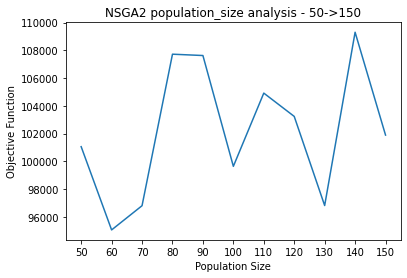

In [ ]:
with open("NSGA2_population_size_fine_tune.dict", "rb") as f:
    result_dict = pickle.load(f)
plot_y=[]
# pop_size_df = pd.DataFrame.from_dict(result_dict)

for pop_size in result_dict.keys():
    plot_y.append(1*(np.asarray(result_dict[pop_size]).max()))
plt.plot(list(result_dict.keys()), plot_y)
plt.title("NSGA2 population_size analysis - 50->150")
plt.xlabel("Population Size")
plt.ylabel("Objective Function")
plt.show()